In [71]:
!pip install transformers
!pip install keras_tuner
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [73]:
import pandas as pd
import numpy as np
import utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AutoTokenizer, TFBertModel

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt

Using GPU if available

In [74]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Preprocessing

The primary data for the competition is, in each provided file, the *comment_text* column. This contains the text of a comment which has been labeled as **Conspiratorial** (1) or **non-conspiratorial** (0). The train set’s comments are entirely in Italian with sporadic citation of external resources in English and come exclusively from Telegram Channels.

The **subtaskA_train.csv** contains a *conspiratorial* column that it is the target to be trained on. The values of such column are either 1 indicating that the corresponding comment in *comment_text* column is Conspiratorial. Otherwise it is 0.

## Loading dataset

In [75]:
df = pd.read_csv("subtaskA_train.csv")

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


By plotting the distribution for text length, we can see that the majority of messages have a short length, showing a power law distribution.

<Axes: >

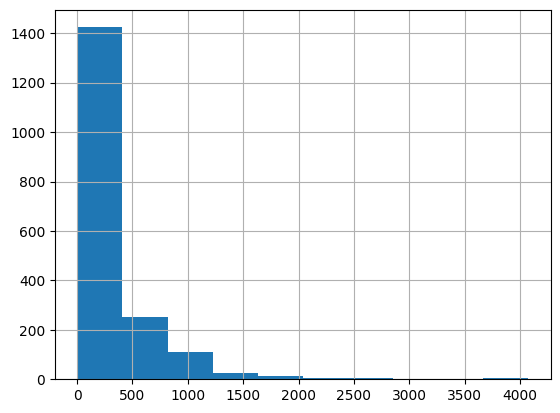

In [77]:
df["comment_text"].map(len).hist()

The labels are well-balanced.

<Axes: >

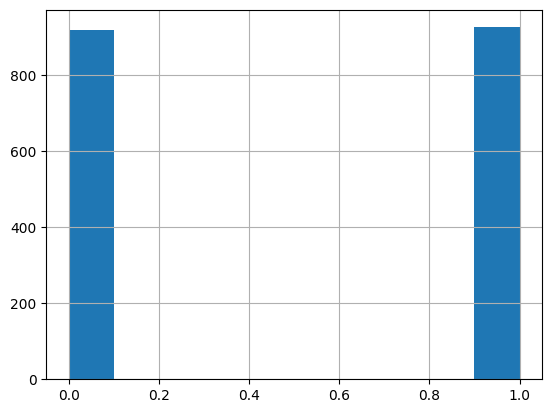

In [78]:
df["conspiratorial"].hist()

## Building train and test set

Assigning 10% of the data to the test set, specifying (using the parameter _stratify_) that the dataset has to be balanced regarding the label "conspirational"

In [79]:
X = df["comment_text"]
y = df["conspiratorial"]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.10, random_state = 10)

# Model training

## Architecture definition

In this notebook the task has been addressed by using the [**Multilingual Universal Sentence Encoder**](https://arxiv.org/pdf/1907.04307.pdf). It's a multilingual text encoder trained by Google on 16 languages (including italian) and freely available on [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3).

This encoder relies on [SentencePiece](https://aclanthology.org/D18-2012.pdf) tokenizer.

In [81]:
tfhub_handle_encoder = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
tfhub_handle_preprocess = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"

In [82]:
def build_model_with_hp(
    gru_units: int,
    l1_units: int,
    l2_units: int,
    l3_units: int,
    l2_value: float,
    dropout_rate: float,
    learning_rate: float,
    epsilon: float,
    clipnorm: float
):
    # defining inputs
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # defining preprocessing
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

    # defining encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='text_encoder')
    net = encoder(text_input)

    # Reshape net to add a time step dimension
    net = tf.expand_dims(net, axis=1)

    net = GRU(
        units = gru_units,
        kernel_regularizer = regularizers.L2(l2_value),
        dropout = dropout_rate,
        name = "GRU_layer")(net)

    # FULLY CONNECTED LAYERS

    net = tf.keras.layers.Dense(
        units = l1_units,
        kernel_regularizer = regularizers.L2(l2_value),
        activation = "relu",
        name = "Dense_layer_1"
    )(net)

    net = Dropout(rate=dropout_rate)(net)

    net = tf.keras.layers.Dense(
        units = l2_units,
        kernel_regularizer = regularizers.L2(l2_value),
        activation="relu",
        name = "Dense_layer_2"
    )(net)

    net = Dropout(rate=dropout_rate)(net)

    net = tf.keras.layers.Dense(
        units = l3_units,
        kernel_regularizer = regularizers.L2(l2_value),
        activation="relu",
        name = "Dense_layer_3"
    )(net)

    net = Dropout(rate=dropout_rate)(net)

    # OUTPUT LAYER
    net = tf.keras.layers.Dense(
        units = 1,
        kernel_regularizer = regularizers.L2(l2_value),
        activation = "sigmoid",
        name = 'classifier'
    )(net)

    model = tf.keras.Model(text_input, net)

    optimizer = Adam(
        learning_rate = learning_rate,
        epsilon = epsilon,
        clipnorm = clipnorm
    )

    model.compile(
        optimizer = optimizer,
        loss = 'binary_crossentropy',
        metrics = 'accuracy'
    )

    return model

def build_classifier_model(hp):
    gru_units = hp.Int('gru_units', min_value=4, max_value=10, step=1)
    l1_units = hp.Int('l1_units', min_value=5, max_value=40, step=5)
    l2_units = hp.Int('l2_units', min_value=5, max_value=40, step=5)
    l3_units = hp.Int('l3_units', min_value=5, max_value=40, step=5)
    l2_value = hp.Choice('L2 regularization', values = [1e-5, 1e-6])
    dropout_rate = 0.1
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    epsilon = 1e-7
    clipnorm = 0.1

    return build_model_with_hp(gru_units, l1_units, l2_units, l3_units, l2_value, dropout_rate, learning_rate, epsilon, clipnorm)

Along the model, we introduce 2 callbacks to support the model training:


*   **ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
*   **EarlyStopping**: Stop training when a monitored metric has stopped improving.



In [83]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=5e-2,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=1e-3,
    min_lr=1e-5
)
early_stopping = EarlyStopping(monitor='val_accuracy' ,mode='max', patience=20,verbose=False,restore_best_weights=True)

## Performing a random search of the hyperparameters

In [84]:
tuner = kt.RandomSearch(
    hypermodel=build_classifier_model,
    max_trials=10,
    objective='val_accuracy',
    overwrite=True
)

In [85]:
print(f'Training model with {tfhub_handle_encoder}')
tuner.search(
    x = X_train,
    y = y_train,
    epochs = 80,
    validation_split = 0.2,
    callbacks = [
        reduce_lr,
        early_stopping
    ]
)

Trial 10 Complete [00h 01m 08s]
val_accuracy: 0.7680723071098328

Best val_accuracy So Far: 0.7951807379722595
Total elapsed time: 00h 14m 49s


In [86]:
tuner.results_summary(5)

Results summary
Results in ./untitled_project
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
gru_units: 9
l1_units: 20
l2_units: 10
l3_units: 25
L2 regularization: 1e-05
learning_rate: 0.0001
Score: 0.7951807379722595

Trial 08 summary
Hyperparameters:
gru_units: 6
l1_units: 35
l2_units: 10
l3_units: 20
L2 regularization: 1e-06
learning_rate: 0.0001
Score: 0.7921686768531799

Trial 02 summary
Hyperparameters:
gru_units: 4
l1_units: 15
l2_units: 40
l3_units: 5
L2 regularization: 1e-06
learning_rate: 0.01
Score: 0.7861445546150208

Trial 05 summary
Hyperparameters:
gru_units: 4
l1_units: 10
l2_units: 15
l3_units: 40
L2 regularization: 1e-06
learning_rate: 0.001
Score: 0.7861445546150208

Trial 03 summary
Hyperparameters:
gru_units: 5
l1_units: 30
l2_units: 30
l3_units: 30
L2 regularization: 1e-05
learning_rate: 0.01
Score: 0.7771084308624268


# Final phase: retrain and test

After the search for optimal parameters we perform another fit on the training set in order to observe closely the learning curves on training and validation.

In [87]:
gru_units = 9
l1_units = 20
l2_units = 10
l3_units = 15
l2_value = 1e-5
dropout_rate = 0.1
learning_rate = 1e-4
epsilon = 1e-7
clipnorm = 0.1

In [88]:
best_model = build_model_with_hp(
    gru_units = gru_units,
    l1_units = l1_units,
    l2_units = l2_units,
    l3_units = l3_units,
    l2_value = l2_value,
    dropout_rate = dropout_rate,
    learning_rate = learning_rate,
    epsilon = epsilon,
    clipnorm = clipnorm
)

print(f'Training model with {tfhub_handle_encoder}')
history = best_model.fit(
    x = X_train,
    y = y_train,
    epochs=70,
    validation_split = 0.2,
    batch_size = 32,
    callbacks= [
      reduce_lr
    ]
)


Training model with https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
Epoch 1/70
42/42 [==============================] - 14s 63ms/step - loss: 0.6948 - accuracy: 0.5019 - val_loss: 0.6937 - val_accuracy: 0.5151 - lr: 1.0000e-04
Epoch 2/70
42/42 [==============================] - 1s 28ms/step - loss: 0.6936 - accuracy: 0.5177 - val_loss: 0.6925 - val_accuracy: 0.5271 - lr: 1.0000e-04
Epoch 3/70
42/42 [==============================] - 1s 27ms/step - loss: 0.6924 - accuracy: 0.5517 - val_loss: 0.6910 - val_accuracy: 0.6054 - lr: 1.0000e-04
Epoch 4/70
42/42 [==============================] - 1s 35ms/step - loss: 0.6912 - accuracy: 0.5691 - val_loss: 0.6892 - val_accuracy: 0.6235 - lr: 1.0000e-04
Epoch 5/70
42/42 [==============================] - 2s 53ms/step - loss: 0.6895 - accuracy: 0.5781 - val_loss: 0.6869 - val_accuracy: 0.6476 - lr: 1.0000e-04
Epoch 6/70
42/42 [==============================] - 1s 35ms/step - loss: 0.6876 - accuracy: 0.6143 - val_loss: 0.6844 - va

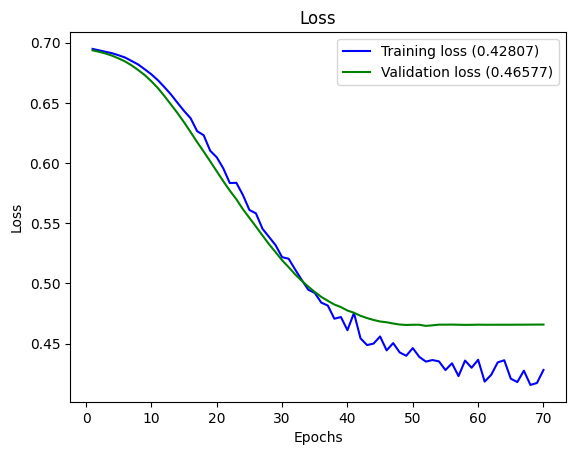

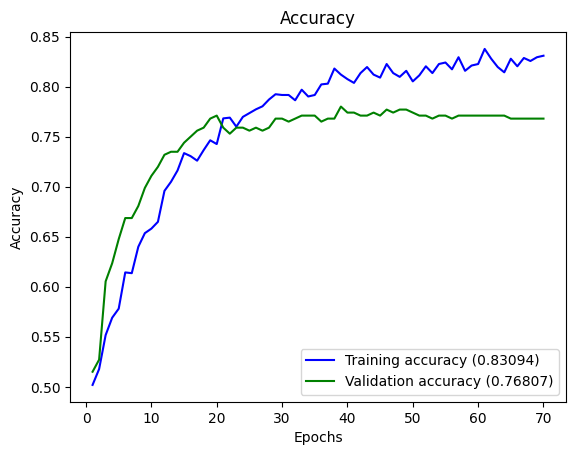

In [89]:
utils.plot_history(history)

## Retrain on training and validation

Before testing our model, we retrain it on training and validation set using the best hyperparams found by the random search

In [91]:
final_model = build_model_with_hp(
    gru_units = gru_units,
    l1_units = l1_units,
    l2_units = l2_units,
    l3_units = l3_units,
    l2_value = l2_value,
    dropout_rate = dropout_rate,
    learning_rate = learning_rate,
    epsilon = epsilon,
    clipnorm = clipnorm
)

max_epochs = 35

In [92]:
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = final_model.fit(
    x = X_train,
    y = y_train,
    epochs=max_epochs,
    batch_size = 32,
)


Training model with https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
Epoch 1/35
52/52 [==============================] - 11s 24ms/step - loss: 0.6940 - accuracy: 0.5069
Epoch 2/35
52/52 [==============================] - 1s 22ms/step - loss: 0.6936 - accuracy: 0.5069
Epoch 3/35
52/52 [==============================] - 1s 22ms/step - loss: 0.6933 - accuracy: 0.5136
Epoch 4/35
52/52 [==============================] - 1s 22ms/step - loss: 0.6928 - accuracy: 0.5160
Epoch 5/35
52/52 [==============================] - 1s 22ms/step - loss: 0.6918 - accuracy: 0.5275
Epoch 6/35
52/52 [==============================] - 1s 23ms/step - loss: 0.6900 - accuracy: 0.5293
Epoch 7/35
52/52 [==============================] - 1s 23ms/step - loss: 0.6874 - accuracy: 0.5673
Epoch 8/35
52/52 [==============================] - 1s 28ms/step - loss: 0.6843 - accuracy: 0.5782
Epoch 9/35
52/52 [==============================] - 2s 38ms/step - loss: 0.6800 - accuracy: 0.6144
Epoch 10/35
52/52 [==

In [93]:
final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 text_encoder (KerasLayer)   (None, 512)               68927232  
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1, 512)           0         
 a)                                                              
                                                                 
 GRU_layer (GRU)             (None, 9)                 14121     
                                                                 
 Dense_layer_1 (Dense)       (None, 20)                200       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                           

## Predict on test set

In [94]:
_ = final_model.evaluate(
    x=X_test,
    y=y_test,
    batch_size=32
)

6/6 [==============================] - 1s 25ms/step - loss: 0.4748 - accuracy: 0.7784


6/6 [==============================] - 1s 22ms/step


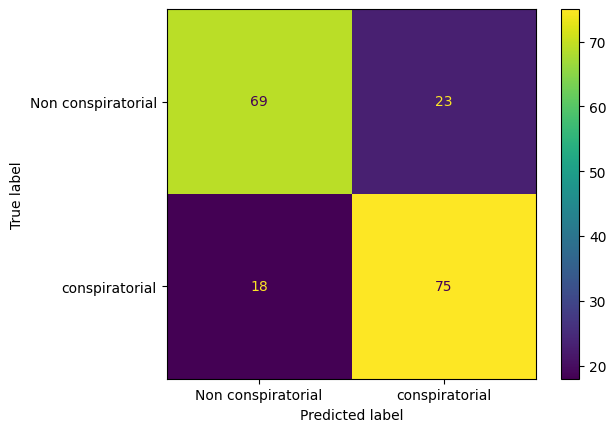

In [95]:
predictions = final_model.predict(x=X_test)
predictions = list(map(round, [ _[0] for _ in predictions]))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non conspiratorial", "conspiratorial"])
disp.plot()